In [6]:
import pandas as pd
import pycountry
import re
import geopandas as gpd
import matplotlib.pyplot as plt

articles = pd.read_csv("articles.CDKN2A.csv")
authors = pd.read_csv("authors.CDKN2A.csv")
paper = pd.read_csv("paper_counts.csv")

C:\Users\fairy\AppData\Local\Temp\ipykernel_17368\3466111738.py:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


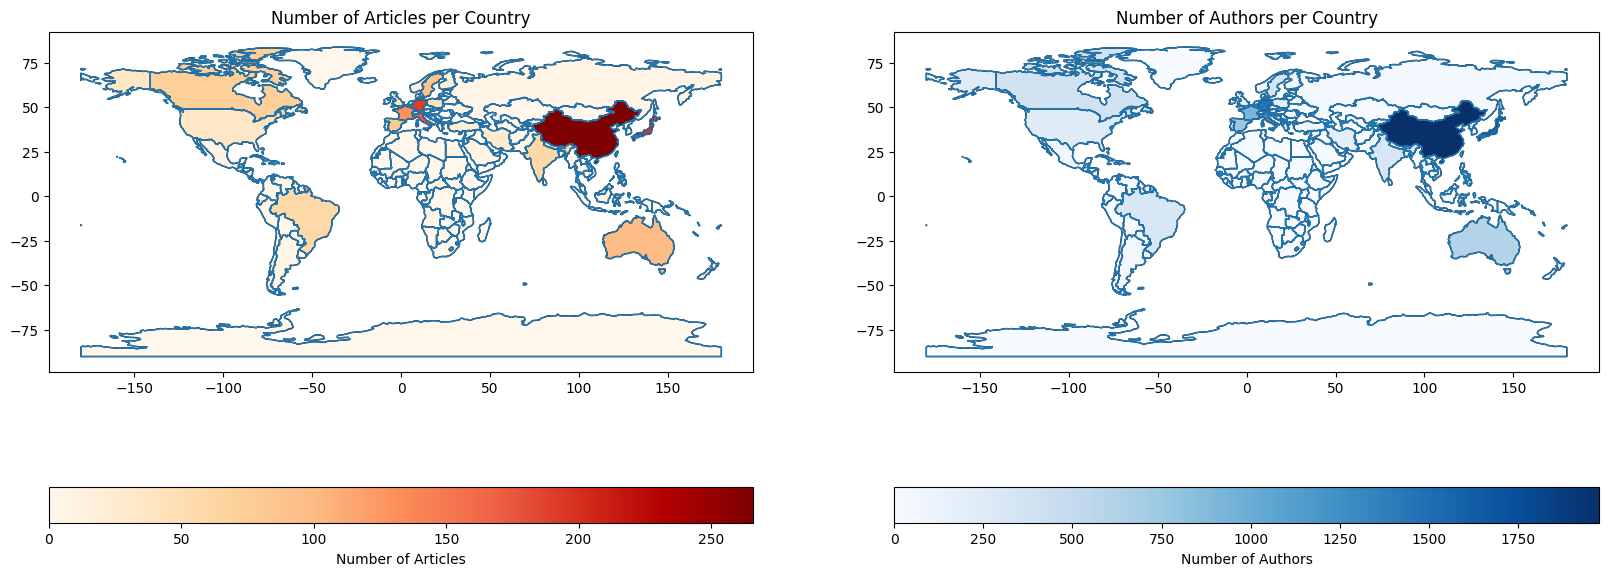

In [13]:
def extract_country(affiliation):
    """
    从作者单位信息中提取国家名。
    """
    if pd.isna(affiliation):
        return "Unknown"
    try:
        # 假设国家名是字符串中的最后一个词
        country = affiliation.split(',')[-1].strip()
        # 移除常见的非国家术语和额外空格
        country = re.sub(r"(University|Institute|Hospital|Department|College|School).*$", "", country).strip()
        return country
    except:
        return "Unknown"

def clean_country_name(country):
    """
    清理提取出的国家名，移除任何非国家术语和电子邮件地址。
    """
    country = re.sub(r"\..*|\s\-\s.*", "", country)
    return country

# 应用函数到相关列
articles['articles_country'] = articles['FirstAuthorAffiliation'].apply(extract_country).apply(clean_country_name)
authors['authors_country'] = authors['AuthorAffiliation'].apply(extract_country).apply(clean_country_name)

# 按国家分组并计算文章和作者的数量
articles_count = articles['articles_country'].value_counts().reset_index()
articles_count.columns = ['Country', 'ArticleCount']

authors_count = authors['authors_country'].value_counts().reset_index()
authors_count.columns = ['Country', 'AuthorCount']

# 使用替代方法加载世界地图数据
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 将计数与世界地图数据合并
world = world.merge(articles_count, left_on='name', right_on='Country', how='left')
world = world.merge(authors_count, left_on='name', right_on='Country', how='left')

# 用0填充NaN值以便于可视化
world['ArticleCount'] = world['ArticleCount'].fillna(0)
world['AuthorCount'] = world['AuthorCount'].fillna(0)

# 绘制两个地图：一个显示文章数量，另一个显示作者数量
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# 文章数量地图
world.boundary.plot(ax=ax[0], linewidth=1)
world.plot(column='ArticleCount', ax=ax[0], legend=True,
           legend_kwds={'label': "Number of Articles", 'orientation': "horizontal"},
           cmap='OrRd', edgecolor='black')
ax[0].set_title('Number of Articles per Country')

# 作者数量地图
world.boundary.plot(ax=ax[1], linewidth=1)
world.plot(column='AuthorCount', ax=ax[1], legend=True,
           legend_kwds={'label': "Number of Authors", 'orientation': "horizontal"},
           cmap='Blues', edgecolor='black')
ax[1].set_title('Number of Authors per Country')

plt.show()
